In [1]:
sc

<SparkContext master=local[*] appName=PySparkShell>

## Importing Necessary Libraries

In [4]:
# Standard Libraries
import time
from queue import Queue
from threading import Thread

# Data Processing Libraries
import numpy as np
import pandas as pd

# Visualization Libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Machine Learning and Utilities
import tflite_runtime.interpreter as tflite
from pyspark.sql import SparkSession
from sklearn.metrics import confusion_matrix
import warnings

warnings.filterwarnings('ignore')

## Initializing Spark Session

In [5]:
spark = SparkSession.builder.appName("AnomalyDetection").getOrCreate()

## Loading the Data

In [6]:
# Read the file for streaming as a Dataframe
df = spark.read.csv("../Data/EncodedStreamingDataset.csv", header=True, inferSchema=True)
numpy_array = df.toPandas()

23/10/07 05:17:43 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


## Loading TensorFlow Lite Model

In [7]:
# Load the .tflite model
interpreter = tflite.Interpreter(model_path="../Models/OptimizedNeuralNetwork.tflite")
interpreter.allocate_tensors()

input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


## Stream Data and Predictive Model Handlers

In [13]:
# Function simulating the incoming stream of data
def stream_data(df, q, sleep_time=0.1, num_rows=None):
    """Simulate streaming by sending samples to a queue with delay."""
    # Set the option to add custom amounth of data for testing
    if num_rows is not None:
        df = df.head(num_rows)
        
    for index, row in df.iterrows():
        q.put(row)
        time.sleep(sleep_time)

# Function to handle data and make predictions
def handle_data(q, y_true_list, y_pred_list):
    """Handle incoming data, make predictions and update true and predicted labels list."""
    while True:
        data_row = q.get()
        if data_row is None:  # A sentinel value to end the loop
            break

        # Extract the features and true label from the row
        sample = data_row.drop(labels=["attack"]).values
        y_true = data_row["attack"]

        # Predict using the model
        sample = np.expand_dims(sample, axis=0).astype(input_details[0]['dtype'])
        interpreter.set_tensor(input_details[0]['index'], sample)
        interpreter.invoke()
        output_data = interpreter.get_tensor(output_details[0]['index'])[0]
        
        predicted_label = 1 if output_data[0] >= 0.5 else 0
        
        # Print a message if an anomaly is detected
        #if predicted_label == 1:
        #    print("Anomaly detected")
        
        y_true_list.append(y_true)
        y_pred_list.append(predicted_label)
            
        q.task_done()

## Simulation of Streaming and Prediction

In [14]:
# Lists to store the true and predicted labels
y_true_list = []
y_pred_list = []

# Queue to hold incoming samples
q = Queue(maxsize=100)

# Start the threads  
producer = Thread(target=stream_data, args=(numpy_array, q, 0.1, 1000))
consumer = Thread(target=handle_data, args=(q, y_true_list, y_pred_list))

producer.start()
consumer.start()

# Join the threads
producer.join()
q.put(None)  # This will signal the consumer to finish up
consumer.join()

# Calculate the accuracy
accuracy = np.mean(np.array(y_pred_list) == np.array(y_true_list))
print(f"Accuracy: {accuracy * 100:.2f}%")

Anomaly detected
Anomaly detected
Anomaly detected
Anomaly detected
Anomaly detected
Anomaly detected
Anomaly detected
Anomaly detected
Anomaly detected
Anomaly detected
Anomaly detected
Anomaly detected
Anomaly detected
Anomaly detected
Anomaly detected
Anomaly detected
Anomaly detected
Anomaly detected
Anomaly detected
Anomaly detected
Anomaly detected
Anomaly detected
Anomaly detected
Anomaly detected
Anomaly detected
Anomaly detected
Anomaly detected
Anomaly detected
Anomaly detected
Anomaly detected
Anomaly detected
Anomaly detected
Anomaly detected
Anomaly detected
Anomaly detected
Anomaly detected
Anomaly detected
Anomaly detected
Anomaly detected
Anomaly detected
Anomaly detected


Exception in thread Thread-10 (handle_data):
Traceback (most recent call last):
  File "/usr/lib/python3.10/threading.py", line 1016, in _bootstrap_inner
    self.run()
  File "/usr/lib/python3.10/threading.py", line 953, in run
    self._target(*self._args, **self._kwargs)
  File "/tmp/ipykernel_3985/2114831458.py", line 23, in handle_data
  File "/home/hadoop/.local/lib/python3.10/site-packages/tflite_runtime/interpreter.py", line 940, in invoke
    self._ensure_safe()
  File "/home/hadoop/.local/lib/python3.10/site-packages/tflite_runtime/interpreter.py", line 556, in _ensure_safe
    raise RuntimeError("""There is at least 1 reference to internal data
RuntimeError: There is at least 1 reference to internal data
      in the interpreter in the form of a numpy array or slice. Be sure to
      only hold the function returned from tensor() if you are using raw
      data access.


Anomaly detected
Anomaly detected
Anomaly detected
Anomaly detected
Anomaly detected
Anomaly detected
Anomaly detected
Anomaly detected
Anomaly detected
Anomaly detected
Anomaly detected
Anomaly detected
Anomaly detected
Anomaly detected
Anomaly detected
Anomaly detected
Anomaly detected
Anomaly detected
Anomaly detected
Anomaly detected
Anomaly detected
Anomaly detected
Anomaly detected
Anomaly detected
Anomaly detected
Anomaly detected
Anomaly detected
Anomaly detected
Anomaly detected
Anomaly detected
Anomaly detected
Anomaly detected
Anomaly detected
Anomaly detected
Anomaly detected
Anomaly detected
Anomaly detected
Anomaly detected
Anomaly detected
Anomaly detected
Anomaly detected
Anomaly detected
Anomaly detected
Anomaly detected
Anomaly detected
Anomaly detected
Anomaly detected
Anomaly detected
Anomaly detected
Anomaly detected
Anomaly detected
Anomaly detected
Anomaly detected
Anomaly detected
Anomaly detected
Anomaly detected
Anomaly detected
Anomaly detected
Anomaly detect

## Visualization: Confusion Matrix

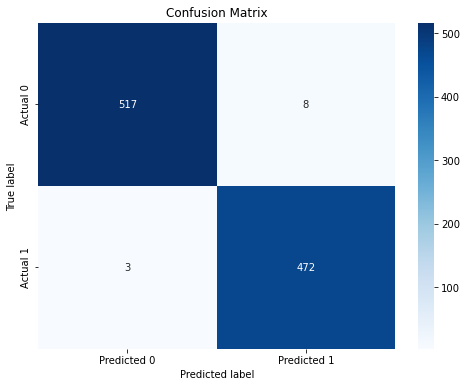

In [15]:
# Compute the confusion matrix
cm = confusion_matrix(y_true_list, y_pred_list)

# Plotting the confusion matrix using Seaborn's heatmap
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', 
            xticklabels=['Predicted 0', 'Predicted 1'], 
            yticklabels=['Actual 0', 'Actual 1'])
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title('Confusion Matrix')
plt.show()